ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 30 sweeps, having no tags, with a total length of 11.11 minutes, recorded without a protocol file.


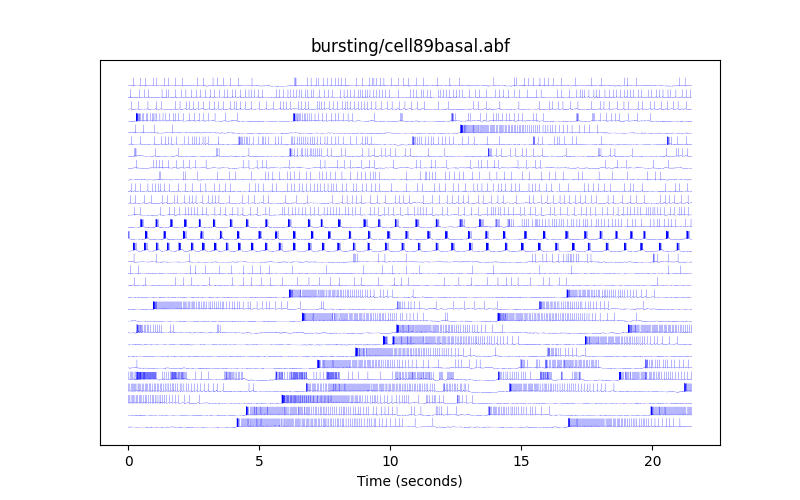

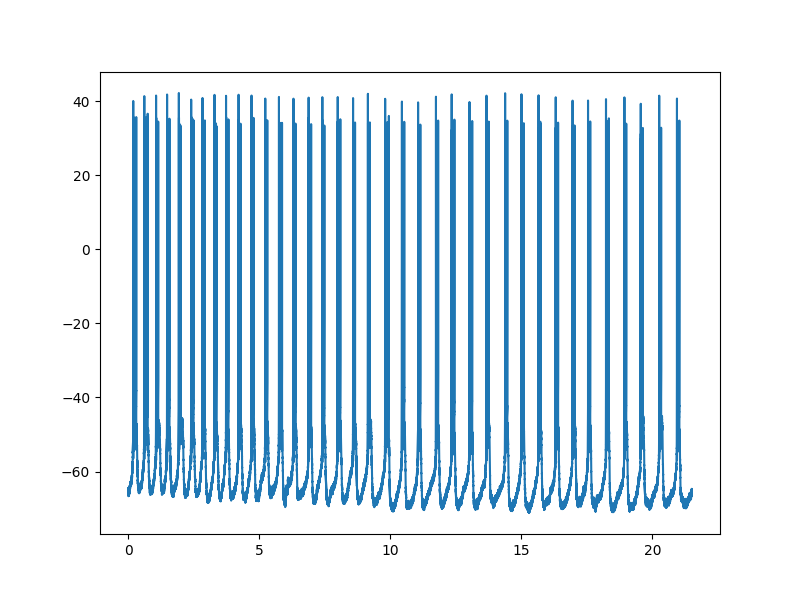

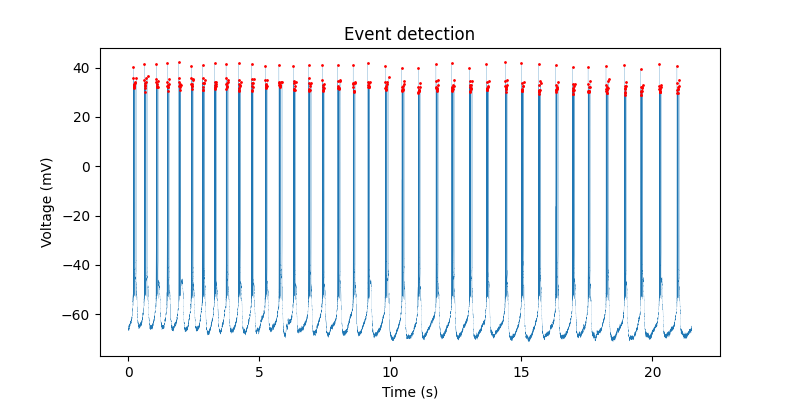

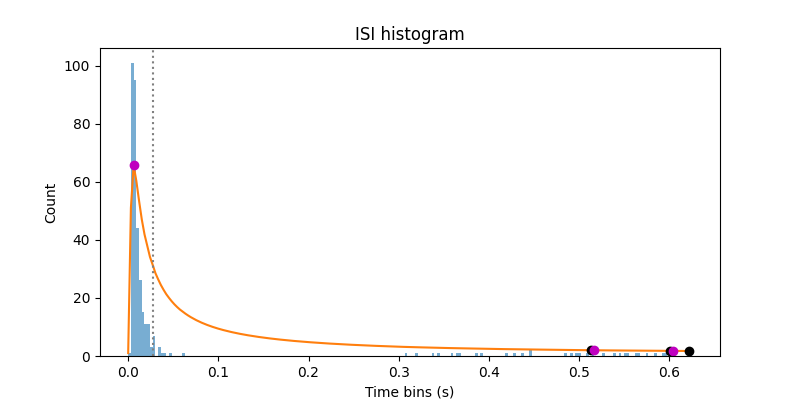

,mean_isi,median_isi,kurtosis,skewness,cma_threshold,cma_valley_time,cma_peak_time
0,0.05835,0.0082,74.182025,8.435033,0.027,0.597,0.006


In [1]:
import pyabf  # Load pyABF
import matplotlib.pyplot as plt
%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
import seaborn as sns

file_path_89 = "bursting/cell89basal.abf"  # we select the abf record file
abf = pyabf.ABF(file_path_89)                 # we load it
print(abf)  

def plot_abf():
    plt.figure(figsize=(8, 5))

    # Plot every sweep with vertical offset
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        offset = 140 * sweepNumber
        plt.plot(abf.sweepX, abf.sweepY + offset, color='b', lw=0.1)  # Recorded voltage
        #plt.plot(abf.sweepX, abf.sweepC + offset, color='r', lw=0.5)  # Command waveform in red

    # Decorate the plot
    plt.gca().get_yaxis().set_visible(False)  # Hide Y axis
    plt.title(file_path_89)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

plot_abf()

# Sampling rate
fs = int(abf.dataPointsPerMs * 1000)

# Assign the variables here to simplify the code
abf.setSweep(15)
time = abf.sweepX
peaks_signal = abf.sweepY  # Or signal_filtered

plt.figure(figsize=(8, 6))
plt.plot(time,peaks_signal)
plt.show()

# Set parameters for the Find peaks function (set to None if not needed)
thresh_min = -35                    # Min threshold to detect spikes
thresh_prominence = 15              # Min spike amplitude  
thresh_min_width = 0.3 * (fs/1000)  # Min required width in ms
distance_min = 1 * (fs/1000)        # Min horizontal distance between peaks
pretrigger_window = (1.5 * fs)/1000
posttrigger_window = (2 * fs)/1000
 
# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, 
           height=thresh_min, 
           threshold=thresh_min,  
           distance=distance_min,  
           prominence=thresh_prominence,  
           width=thresh_min_width, 
           wlen=None,       # Window length to calculate prominence
           rel_height=0.5,  # Relative height at which the peak width is measured
           plateau_size=None)
  
# Create table with results
spikes_table = pd.DataFrame(columns = ['spike', 'spike_index', 'spike_time',
                                       'inst_freq', 'isi_s',
                                       'width', 'rise_half_ms', 'decay_half_ms',
                                       'spike_peak', 'spike_amplitude'])
 
spikes_table.spike = np.arange(1, len(peaks) + 1)
spikes_table.spike_index = peaks
spikes_table.spike_time = peaks / fs  # Divided by fs to get s
spikes_table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
spikes_table.inst_freq = 1 / spikes_table.isi_s
spikes_table.width = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
spikes_table.rise_half_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
spikes_table.decay_half_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
spikes_table.spike_peak = peaks_dict['peak_heights']  # height parameter is needed
spikes_table.spike_amplitude = peaks_dict['prominences']  # prominence parameter is needed
      
# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, peaks_signal,lw=0.1)
 
# Red dot on each detected spike
ax.plot(peaks/fs, peaks_signal[peaks], "r.",markersize=2)
 
# Add a number to each detected peak
# for i, txt in enumerate(spikes_table.spike):  
#     ax1.annotate(spikes_table.spike[i], (peaks[i]/fs, peaks_signal[peaks][i]))
 
ax.set_title("Event detection")  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
#ax.axes.set_xlim(0.4, 0.9)  # Zoom in the trace
 
# Show graph and table
plt.show()
spikes_table

# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 3  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)
 
# Calculate peaks and valleys of the cma
cma_peaks_indexes = scipy.signal.argrelextrema(cma, np.greater)
cma_valleys_indexes = scipy.signal.argrelextrema(cma, np.less)
 
# Select the peak you're interested in
peak_index = cma_peaks_indexes[0][0]  # Change second number to select the peak
alpha = cma[peak_index] * 0.5  # Half-peak, adapt the value to your threshold criterion
 
# Calculate cma_threshold_index relative to the selected cma_peak
cma_threshold = (np.argmin(cma[peak_index:] >= alpha) + peak_index) * bin_size/1000
 
# Dataframe with histogram statistics
length = len(hist_stats)
hist_stats.loc[length, 'mean_isi'] = np.mean(hist_data)
hist_stats.loc[length, 'median_isi'] = np.median(hist_data)
hist_stats.loc[length, 'kurtosis'] = kurtosis(hist_counts)
hist_stats.loc[length, 'skewness'] = skew(hist_counts, bias=True)
hist_stats.loc[length, 'cma_threshold'] = cma_threshold
hist_stats.loc[length, 'cma_valley_time'] = cma_valleys_indexes[0][1] * bin_size/1000  # Change peak index as needed
hist_stats.loc[length, 'cma_peak_time'] = cma_peaks_indexes[0][0] * bin_size/1000  # Change peak index as needed
 
# Plot ISI histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("ISI histogram") 
ax.hist(hist_data, bins=bins, alpha=0.6)
 
# Plot CMA
cma_x = np.linspace(np.min(hist_bins), np.max(hist_bins), bins)
ax.plot(cma_x, cma)
 
# Plot CMA threshold line
ax.axvline(cma_threshold, linestyle="dotted", color="gray")
 
# Plot CMA valleys
ax.plot(cma_x[cma_valleys_indexes], cma[cma_valleys_indexes], 'ko')
ax.plot(cma_x[cma_peaks_indexes], cma[cma_peaks_indexes], 'mo')
 
# ax.set_xscale('log')  # Logarithmic scale may be easier to set the threshold
ax.set_xlabel("Time bins (s)")
ax.set_ylabel("Count")
 
# Show graph and table
plt.show()
hist_stats

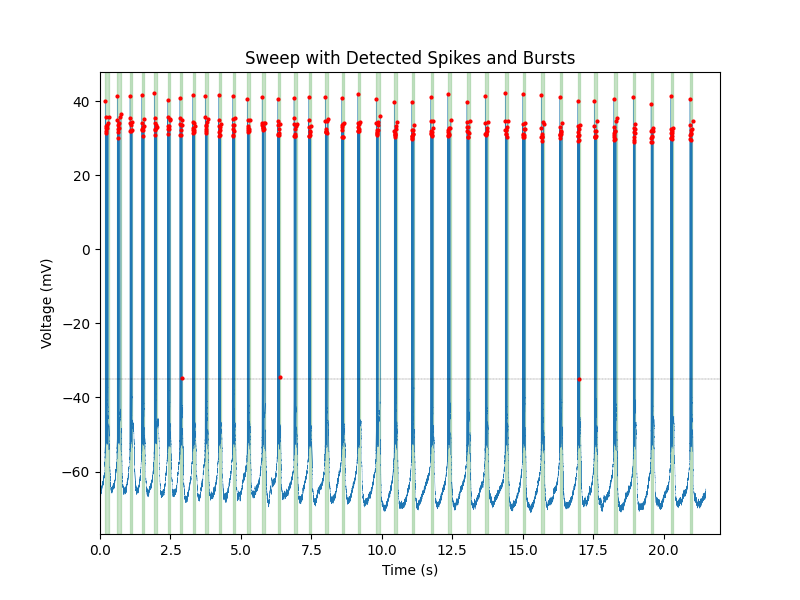

In [2]:
abf = pyabf.ABF(file_path_89)
abf.setSweep(15)

# Extract sweep data
time = abf.sweepX  # Time axis for the sweep
voltage = abf.sweepY  # Voltage data for the sweep

# Detect spikes using a threshold or peak detection
threshold = -35  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
# Detect spikes
threshold = -35  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to times

# Detect bursts based on ISI
isi = np.diff(spike_times)  # Inter-spike intervals
burst_threshold = 0.3  # Define an ISI threshold for bursts (e.g., 20 ms)

# Identify bursts
bursts = []
current_burst = [spike_times[0]]  # Initialize the first burst with the first spike
for i in range(1, len(isi)):
    if isi[i - 1] < burst_threshold:  # Continue the burst
        current_burst.append(spike_times[i])
    else:  # End the current burst and start a new one
        if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# Plot the sweep, spikes, and bursts
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, label='Sweep Data',lw=0.2)
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

# Highlight bursts with shaded regions
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.2, label='Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold',lw=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Bursts")
plt.xlim((0,22))
#plt.legend()
plt.show()

# Print detected bursts
#for i, (burst_start, burst_end) in enumerate(bursts):
#    print(f"Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

Se detectaron 37 bursts


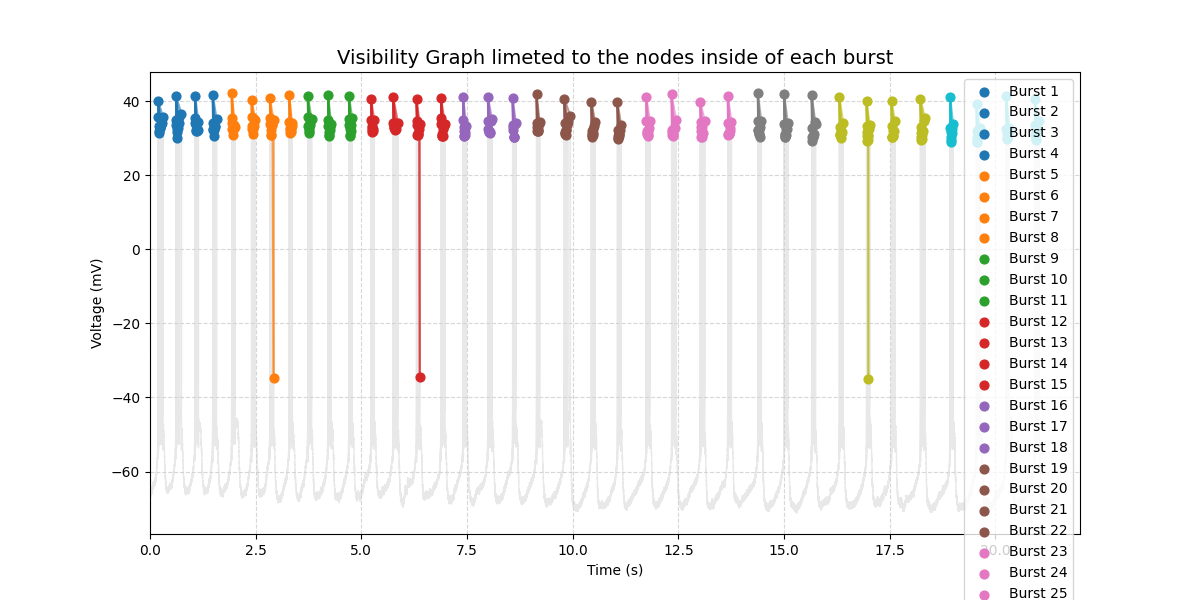

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pyabf
from scipy.signal import find_peaks

# =========================
# 1. Cargar archivo ABF
# =========================
file_path_89 = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path_89)
abf.setSweep(15)

time = abf.sweepX      # eje tiempo
voltage = abf.sweepY   # señal
fs = abf.dataRate      # frecuencia de muestreo

# =========================
# 2. Detección de spikes
# =========================
threshold = -35  # mV
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]
spike_voltages = voltage[spike_indices]

# =========================
# 3. Detección de bursts (umbral ISI)
# =========================
isi = np.diff(spike_times)  # intervalos entre spikes
burst_threshold = 0.3       # en segundos (ej: 300 ms)

bursts = []
current_burst = [0]  # guardar índices de spikes (no tiempos)
for i in range(1, len(spike_times)):
    if isi[i-1] < burst_threshold:
        current_burst.append(i)
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [i]
# último burst
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Se detectaron {len(bursts)} bursts")

# =========================
# 4. Grafo de visibilidad SOLO dentro de bursts
# =========================
plt.figure(figsize=(12,6))
plt.plot(time, voltage, color='lightgray', linewidth=1, alpha=0.5)

colors = plt.cm.tab10(np.linspace(0,1,len(bursts)))  # colores diferentes por burst

for b_idx, burst in enumerate(bursts):
    x_peaks = spike_times[burst]
    y_peaks = spike_voltages[burst]

    # visibilidad entre spikes del mismo burst
    for a in range(len(x_peaks)):
        for b in range(a+1, len(x_peaks)):
            visible = True
            for c in range(a+1, b):
                y_line = y_peaks[b] + (y_peaks[a]-y_peaks[b])*(x_peaks[b]-x_peaks[c])/(x_peaks[b]-x_peaks[a])
                if y_peaks[c] >= y_line:
                    visible = False
                    break
            if visible:
                plt.plot([x_peaks[a], x_peaks[b]],
                         [y_peaks[a], y_peaks[b]],
                         color=colors[b_idx], alpha=0.6)

    # nodos de ese burst
    plt.scatter(x_peaks, y_peaks, color=colors[b_idx], s=40, zorder=5, label=f"Burst {b_idx+1}")

# =========================
# 5. Etiquetas y mostrar
# =========================
plt.title("Visibility Graph limeted to the nodes inside of each burst", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.xlim((0,22))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()